In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/train.csv")

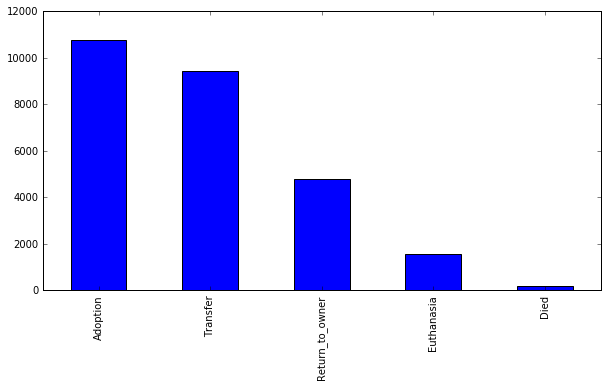

In [2]:
# Visualizations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)


df.OutcomeType.value_counts().plot(kind='bar')

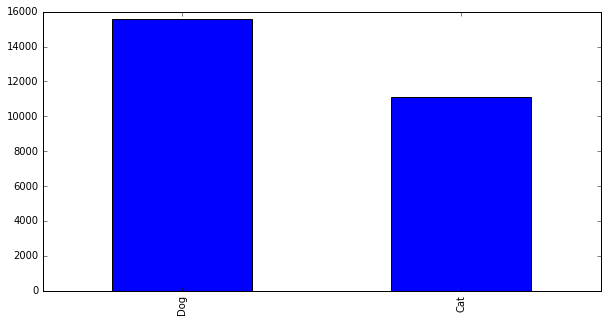

In [3]:
df.AnimalType.value_counts().plot(kind='bar')

[6497 4286 3917  845   50]
Index([u'Adoption', u'Return_to_owner', u'Transfer', u'Euthanasia', u'Died'], dtype='object')


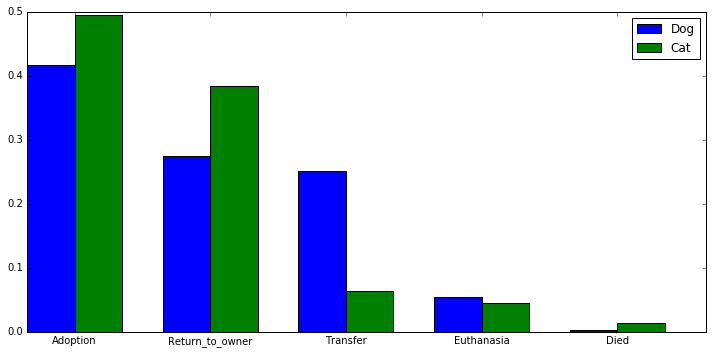

In [4]:
dog = df[df["AnimalType"] == "Dog"]["OutcomeType"].value_counts()
cat = df[df["AnimalType"] == "Cat"]["OutcomeType"].value_counts()
print(dog.values)
print(dog.keys())
keys = dog.keys()
y_pos = np.arange(len(keys))
bar_width=0.35

plt.bar(y_pos, dog.values / float(len(df[df["AnimalType"] == "Dog"])), bar_width, label="Dog", color='b')
plt.bar(y_pos + bar_width, cat.values / float(len(df[df["AnimalType"] == "Cat"])), bar_width, label="Cat", color='g')
plt.xticks(y_pos + bar_width, keys)
plt.tight_layout()
plt.legend()
plt.show()


([<matplotlib.axis.XTick at 0x109056f90>,
 <a list of 5 Text xticklabel objects>)

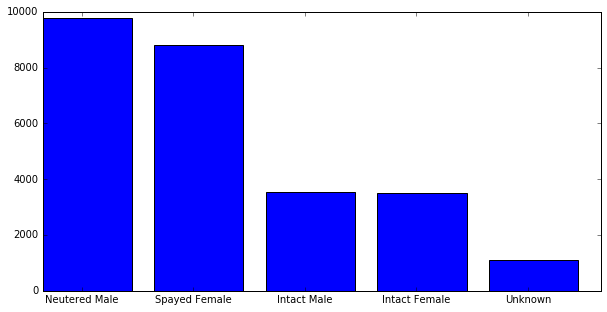

In [5]:
sex = df["SexuponOutcome"].value_counts()
keys = sex.keys()
pos = np.arange(len(keys))
bar_width = 0.35

plt.bar(pos, sex.values)
plt.xticks(pos + bar_width, keys)

In [6]:
def age_in_weeks(time_str):
    num = time_str.split(" ")[0]
    if 'year' in time_str:
        return int(num) * 365
    if 'month' in time_str:
        return int(num) * 30
    if 'week' in time_str:
        return int(num) * 7
    if 'day' in time_str:
        return int(num)

def breed_map(breed):
    return breed.split("/")[0]

def make_features(df):
    df.dropna(subset=['AgeuponOutcome'], inplace=True)
    df["AgeInWeeks"] = df['AgeuponOutcome'].apply(age_in_weeks)
    df = pd.concat([df, pd.get_dummies(df["SexuponOutcome"])], axis=1)
    df = pd.concat([df, pd.get_dummies(df["Color"])], axis=1)
    df = pd.concat([df, pd.get_dummies(df["AnimalType"])], axis=1)
    df["DayOfYear"] = (pd.to_datetime(df["DateTime"]).astype(int) / 1000000000 / 60 / 60 / 24) % 365
    df["HasName"] = df["Name"].isnull().astype(int)
    df["IsMixed"] = df["Breed"].apply(lambda x: 1 if "Mix" in x else 0)
    df["Breed"] = df["Breed"].apply(breed_map)
    df.drop([
        "AnimalID",
        "SexuponOutcome",
        "Color",
        "AnimalType",
        "DateTime",
        "OutcomeSubtype",
        "Name",
        "AgeuponOutcome"
    ],
    inplace=True,
    axis=1)
    print("Length after dropping", len(df))
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()    
    return df

In [7]:
df = make_features(df)

('Length after dropping', 26711)


In [8]:
# Make features

training_data = df[df["Dog"] == 1].drop(["OutcomeType"], axis=1)
test_data = df[df["Dog"] == 1]["OutcomeType"]


In [9]:
print(training_data.columns)
print(training_data.isnull().any().any())

Index([u'Breed', u'AgeInWeeks', u'Intact Female', u'Intact Male',
       u'Neutered Male', u'Spayed Female', u'Unknown', u'Agouti',
       u'Agouti/Brown Tabby', u'Apricot',
       ...
       u'Yellow Brindle/Tan', u'Yellow Brindle/White', u'Yellow/Black',
       u'Yellow/White', u'Yellow/Yellow', u'Cat', u'Dog', u'DayOfYear',
       u'HasName', u'IsMixed'],
      dtype='object', length=378)
False


In [10]:
from sklearn.preprocessing import LabelEncoder
breed_label_encoder = LabelEncoder()
training_data["Breed"] = breed_label_encoder.fit_transform(training_data["Breed"])


In [11]:
# Add color as one hot encoded
training_data = training_data.values
test_data = test_data.values
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from scipy.stats import randint as sp_randint

folds = KFold(n_splits=4)

outcome_label_encoder = LabelEncoder()
test_data = outcome_label_encoder.fit_transform(test_data)
classifier_rf = RandomForestClassifier(**{'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': 10, 'max_depth': None})

# param_dist = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# classifier = RandomizedSearchCV(classifier_rf, param_distributions=param_dist, n_iter=20)
# print("Configured params_dist with", param_dist)


In [12]:

for train_idxs, test_idxs in folds.split(training_data):
    X, y = training_data[train_idxs], test_data[train_idxs]
    X_test, y_test = training_data[test_idxs], test_data[test_idxs]
    classifier_rf.fit(X, y)
    y_pred = classifier_rf.predict_proba(X_test)
    print("Log Loss", log_loss(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, np.argmax(y_pred, axis=1)))
    # Lets do an ensemble
    

('Log Loss', 1.1375230874317466)
('Accuracy', 0.51833803539369072)
('Log Loss', 1.1385080711754736)
('Accuracy', 0.5085919466529879)
('Log Loss', 1.1662500386060766)
('Accuracy', 0.47819394561313494)
('Log Loss', 1.1702226859990614)
('Accuracy', 0.48614674191893281)


In [13]:
# Now lets do test:
from sklearn.linear_model import LogisticRegression

#param_dist = {"penalty": ['l1', 'l2'],
#              "C": sp_randint(1, 15),}

classifier_lr = LogisticRegression(**{'penalty': 'l1', 'C': 1})
#classifier_lr = RandomizedSearchCV(classifier_lr, param_distributions=param_dist, n_iter=20)

for train_idxs, test_idxs in folds.split(training_data):
    X, y = training_data[train_idxs], test_data[train_idxs]
    X_test, y_test = training_data[test_idxs], test_data[test_idxs]
    classifier_lr.fit(X, y)
    y_pred = classifier_lr.predict_proba(X_test)
    print("Log Loss", log_loss(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, np.argmax(y_pred, axis=1)))


('Log Loss', 1.0476328387415648)
('Accuracy', 0.56245191074634526)
('Log Loss', 1.0320803434081429)
('Accuracy', 0.5614260066683765)
('Log Loss', 1.0489273744827252)
('Accuracy', 0.55207798871216007)
('Log Loss', 1.0241066387104401)
('Accuracy', 0.57260133401744484)


In [14]:
for train_idxs, test_idxs in folds.split(training_data):
    X, y = training_data[train_idxs], test_data[train_idxs]
    X_test, y_test = training_data[test_idxs], test_data[test_idxs]
    classifier_lr.fit(X, y)
    classifier_rf.fit(X, y)

    y_pred_lr = classifier_lr.predict_proba(X_test)
    y_pred_rf = classifier_rf.predict_proba(X_test)
    y_pred = y_pred_lr * 0.9 + y_pred_rf * 0.1
    print("Log Loss", log_loss(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, np.argmax(y_pred, axis=1)))

('Log Loss', 1.0426457298425895)
('Accuracy', 0.56245191074634526)
('Log Loss', 1.0325022518029132)
('Accuracy', 0.56270838676583734)
('Log Loss', 1.0485513015334933)
('Accuracy', 0.55284761416110828)
('Log Loss', 1.0249414740759812)
('Accuracy', 0.56875320677270391)
